In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean
from matplotlib.animation import FuncAnimation

from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [3]:
usrp1_file = 'data_T03_20240523141330.txt'
usrp2_file = 'data_T04_20240523141330.txt'
scope_file = 'data_scope_20240523141330.txt'

In [4]:
# wrap around function which "glues" together 0 and 360 degrees.

def wraparound(arr):
    arr = np.asarray(arr)
    fltr = arr > 180
    arr[fltr] = arr[fltr] - 360
    return arr

In [5]:
df = pd.read_csv(scope_file, names=[
                 "meas_id", "phase_diff"], header=None, sep='\s+')

df.loc[(df['phase_diff'] < 180), 'phase_diff'] = df['phase_diff'].add(360)

df['phase_diff'] -= 360

fields = ["meas_id", "hostname", "meas_type",
          "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "_0", "_1"]

df1 = pd.read_csv(usrp1_file,
                  names=fields, header=None, sep=';')

df2 = pd.read_csv(usrp2_file,
                  names=fields, header=None, sep=';')


# given that we meanly want to plot things, shift the radians to degrees and wrap around
for frame in [df1, df2]:
    for col in ["tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1"]:
        frame.loc[:, col] = wraparound(np.rad2deg(frame[col]))
        


# merge the two dataframes and include the phase diff
merged_df = pd.merge(df1, df2, on=['meas_id', "meas_type"], how='outer',
                     suffixes=('_df1', '_df2'))

merged_df["phase_diff"] = None

# Iterate over rows
for index, row in df.iterrows():
    merged_df.loc[merged_df['meas_id'] ==
                  row['meas_id'], "phase_diff"] = row["phase_diff"]
    


# clean up
df1.drop(columns=["_0", "_1"], inplace=True)
df2.drop(columns=["_0", "_1"], inplace=True)

Mean: 8.40°
circ mean: 2.29°


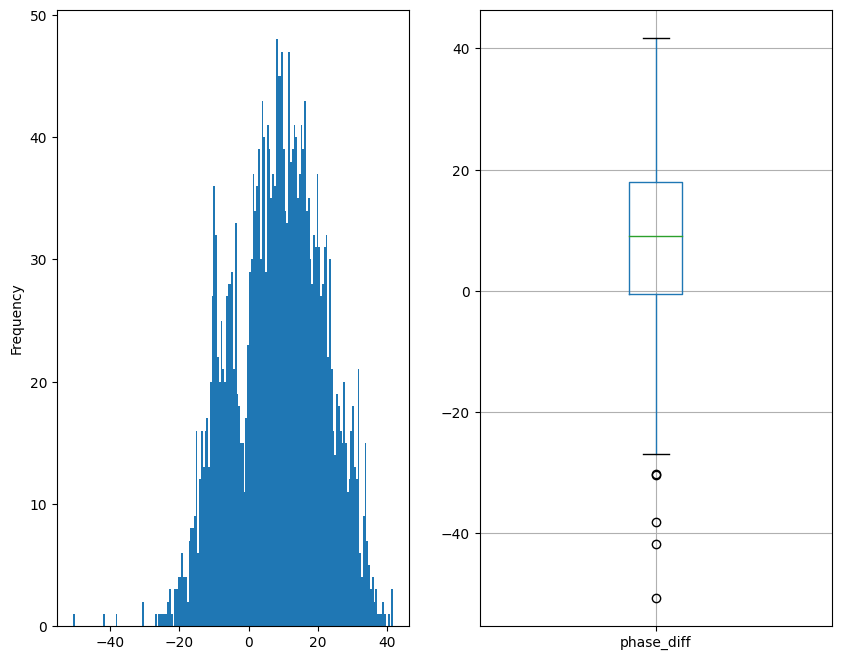

In [6]:
# plot hist and boxplot of the phase difffernce measured by the scope
df.loc[:, 'phase_diff'] = wraparound(df['phase_diff'])

fig, axes = plt.subplots(nrows=1, ncols=2)
df["phase_diff"].plot.hist(figsize=(10, 8), ax=axes[0], bins=180)
df.boxplot(column=['phase_diff'], ax=axes[1])

print(f"Mean: {np.mean(df['phase_diff']):.2f}°")
print(f"circ mean: {circmean(df['phase_diff']):.2f}°")

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

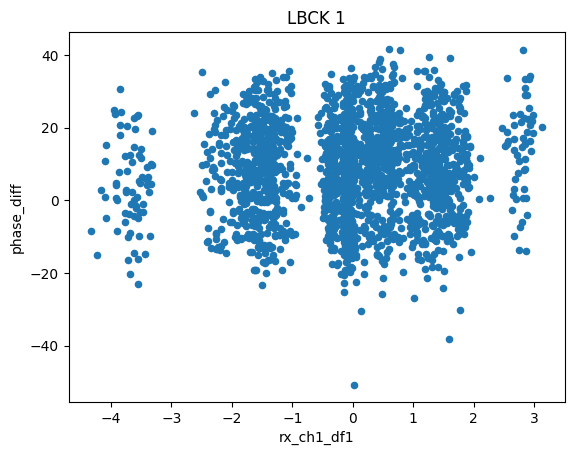

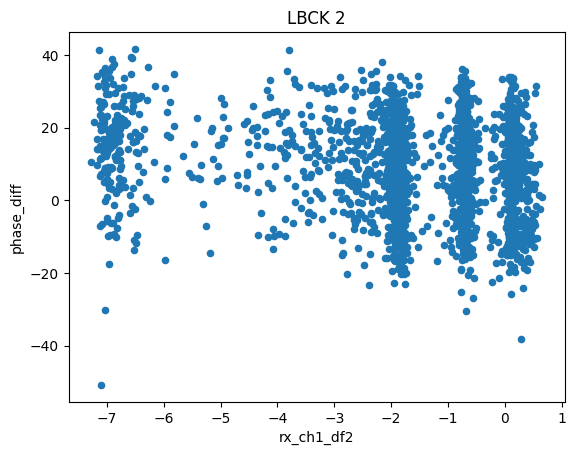

In [7]:
merged_df.where(merged_df['meas_type'] == "LBCK").plot.scatter(x='rx_ch1_df1',
                                                               y='phase_diff', title="LBCK 1");
merged_df.where(merged_df['meas_type'] == "LBCK").plot.scatter(x='rx_ch1_df2',
                                                               y='phase_diff', title="LBCK 2");

Check the accumalated absolute measured loopback check of both USRP.

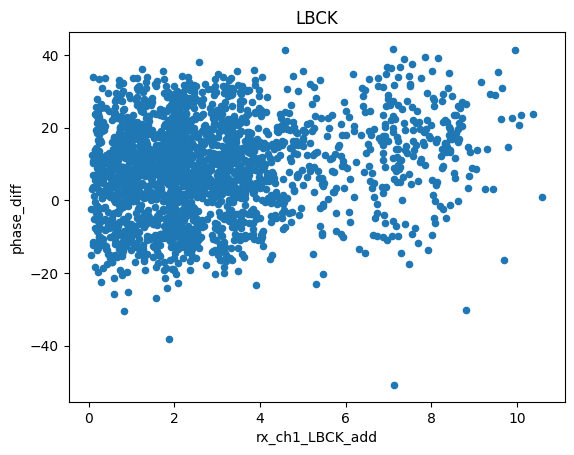

In [8]:
fltr = merged_df['meas_type'] == "LBCK"

merged_df.loc[fltr, 'rx_ch1_LBCK_add'] = np.abs(merged_df.loc[fltr, 'rx_ch1_df1']) + np.abs(merged_df.loc[fltr, 'rx_ch1_df2'])

merged_df.plot.scatter(x='rx_ch1_LBCK_add', y='phase_diff', title="LBCK");

In the following, I am investigating the phase difference when measuring the PLL phase, i.e.,
$$\phi_1 = \phi_{pll}+\phi_{rx, 1}$$
$$\phi_2 = \phi_{pll}+\phi_{rx, 2}$$

I would suspect that due to the dividers in the USRP, $\phi_1$ and $\phi_2$ would overlap when the RX PLLs of both USRPs were aligned (and the received PLL phases are by design aligned). Additionally, 8 clusters of phases should be visible due to the dividers (3 dividers = 2^3 possible phase rotations).

However, we observe that this is not the case and additional, but fixed (in time and power cycle) phase difference between the clusters is observed.

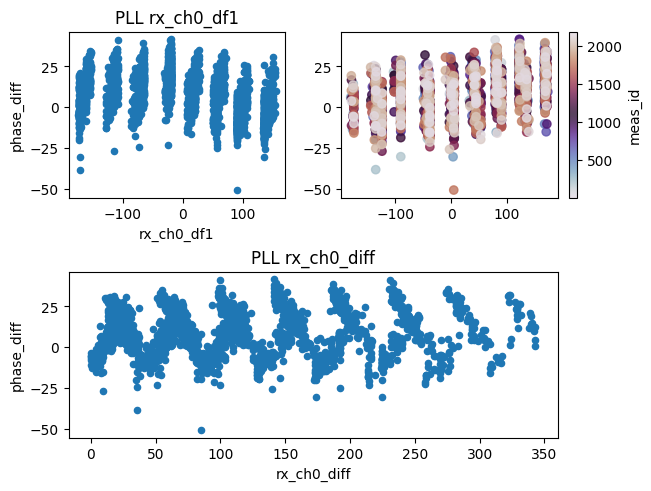

In [9]:
merged_df["rx_ch0_diff"] = np.abs(
    merged_df["rx_ch0_df1"] - merged_df["rx_ch0_df2"])

fig, axd = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']],
                              constrained_layout=True);

merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x='rx_ch0_df1',
                                                              y='phase_diff', title="PLL rx_ch0_df1", ax=axd['left']);


pll_df = merged_df[merged_df['meas_type'] == 'PLL']

# center = int(np.max(pll_df['meas_id'])//2)


# pll1_df = pll_df[pll_df['meas_id'] < center]
# pll2_df = pll_df[pll_df['meas_id'] >= center]

# sc = axd['right'].scatter(pll1_df['rx_ch0_df2'], pll1_df['phase_diff'],
#                           c="blue", alpha=0.6)
# sc = axd['right'].scatter(pll2_df['rx_ch0_df2'], pll2_df['phase_diff'],
#                           c="red", alpha=0.6)
# axd['right'].set_title('PLL rx_ch0_df2')
# axd['right'].set_xlabel('rx_ch0_df2')
# axd['right'].set_ylabel('phase_diff')

sc = axd['right'].scatter(pll_df['rx_ch0_df2'], pll_df['phase_diff'],
                          c=pll_df['meas_id'], cmap='twilight', alpha=0.8)
# Add a color bar to show the scale of meas_id
plt.colorbar(sc, label='meas_id')

# merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x='rx_ch0_df2',
#                                                               y='phase_diff', title="PLL rx_ch0_df2", ax=axd['right'], c="red");

merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x='rx_ch0_diff',
                                                              y='phase_diff', title="PLL rx_ch0_diff", ax=axd['bottom']);

RuntimeError: Requested MovieWriter (ffmpeg) not available

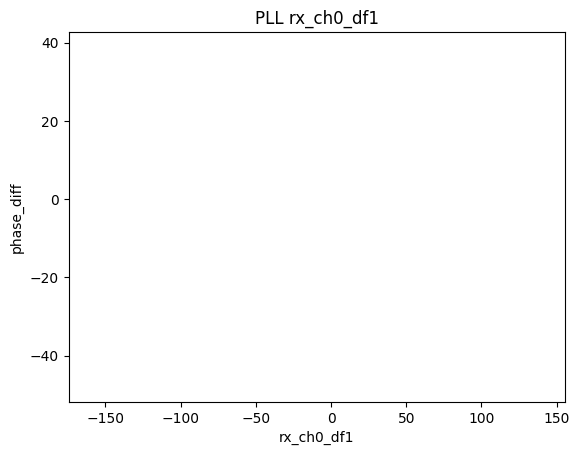

In [10]:

fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df1')
ax.set_xlabel('rx_ch0_df1')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:, ['rx_ch0_df2', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,


max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(1, max_meas_id + 1, step=100), interval=400, blit=True)

anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

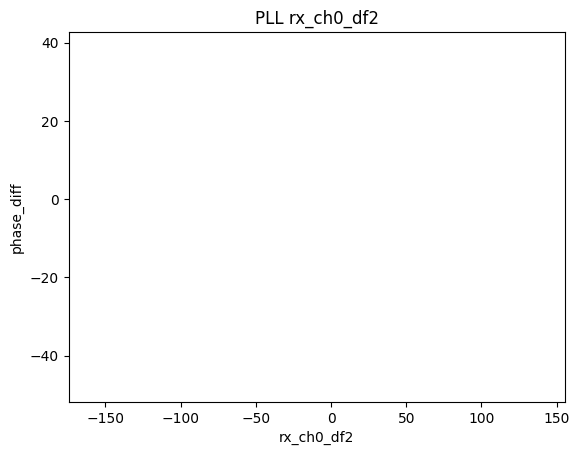

In [11]:
# Step 2: Create the plot
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df2')
ax.set_xlabel('rx_ch0_df2')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:,['rx_ch0_df1', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,

max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                    frames=np.arange(1,max_meas_id + 1,step=100), interval=400, blit=True)

anim